In [1]:
from pytorch_grad_cam import GradCAM, HiResCAM, ScoreCAM, GradCAMPlusPlus, AblationCAM, XGradCAM, EigenCAM, FullGrad
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
from pytorch_grad_cam.utils.image import show_cam_on_image, \
    deprocess_image, \
    preprocess_image

import cv2
import numpy as np
import requests
from PIL import Image
import matplotlib.pyplot as plt
import torch
import torchvision.models as models
from torchvision import transforms
from torch.profiler import profile, ProfilerActivity, record_function

import torchlens

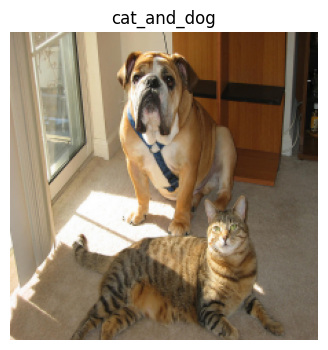

In [2]:
# Load image
cat_and_dog_image_url = "https://raw.githubusercontent.com/jacobgil/pytorch-grad-cam/master/examples/both.png"
cat_and_dog = np.array(Image.open(requests.get(cat_and_dog_image_url, stream=True).raw))
# Display the image using matplotlib
plt.figure(figsize=(5, 4))
plt.imshow(cat_and_dog)
plt.axis('off')  # Hide axes
plt.title('cat_and_dog')
plt.show()

In [3]:
# Convert to float32 first for matplotlib compatibility, then convert back to float16 for model
cat_and_dog = np.float32(cat_and_dog) / 255  # Keep float32 for model
input_tensor = preprocess_image(cat_and_dog, mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])

In [4]:
model = models.resnet50(weights=models.ResNet50_Weights.DEFAULT)
# model = model.half()  # Convert model to half precision (float16)

In [5]:
# Check the model's parameter precision
print(f"Model parameter dtype: {next(model.parameters()).dtype}")
print(f"Input tensor dtype: {input_tensor.dtype}")

Model parameter dtype: torch.float32
Input tensor dtype: torch.float32


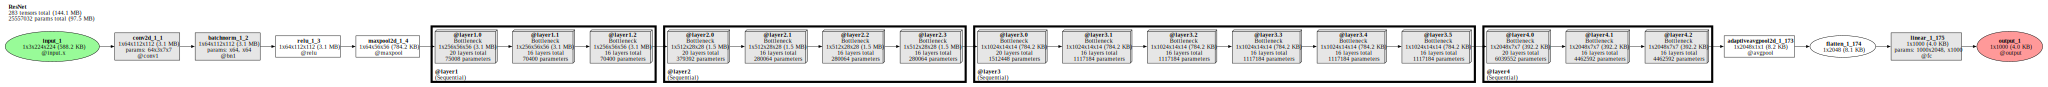

In [14]:
torchlens.show_model_graph(model, input_tensor, vis_opt='unrolled', vis_nesting_depth=2, vis_direction='leftright')

In [15]:
activities = [ProfilerActivity.CPU]
if torch.cuda.is_available():
    device = "cuda"
    activities += [ProfilerActivity.CUDA]
elif torch.xpu.is_available():
    device = "xpu"
    activities += [ProfilerActivity.XPU]
else:
    print(
        "Neither CUDA nor XPU devices are available to demonstrate profiling on acceleration devices"
    )
activities

Neither CUDA nor XPU devices are available to demonstrate profiling on acceleration devices


[<ProfilerActivity.CPU: 0>]

In [16]:
target_layers = [model.layer4]

# Construct the CAM object once, and then re-use it on many images:
cam = GradCAM(model=model, target_layers=target_layers)

# You can also use it within a with statement, to make sure it is freed,
# In case you need to re-create it inside an outer loop:
# with GradCAM(model=model, target_layers=target_layers, use_cuda=args.use_cuda) as cam:
#   ...

# We have to specify the target we want to generate
# the Class Activation Maps for.
# If targets is None, the highest scoring category
# will be used for every image in the batch.
# Here we use ClassifierOutputTarget, but you can define your own custom targets
# That are, for example, combinations of categories, or specific outputs in a non standard model.

targets = [ClassifierOutputTarget(246)] # 281 is the ImageNet index of 'tabby, tabby cat', 246 is 'boxer'

with profile(activities=activities, record_shapes=True) as prof:
    with record_function("model_inference"):
        # You can also pass aug_smooth=True and eigen_smooth=True, to apply smoothing.
        grayscale_cam = cam(input_tensor=input_tensor, targets=targets)

# In this example grayscale_cam has only one image in the batch:
grayscale_cam = grayscale_cam[0, :]
# Use float32 version for visualization to avoid matplotlib issues
visualization = show_cam_on_image(cat_and_dog, grayscale_cam, use_rgb=True)

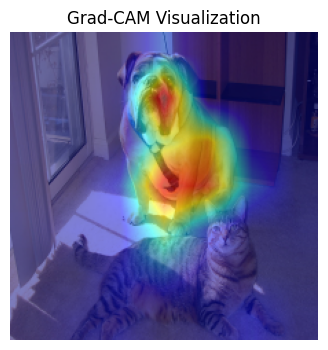

In [23]:
# Display the CAM visualization
plt.figure(figsize=(5, 4))
plt.imshow(visualization)
plt.axis('off')  # Hide axes
plt.title('Grad-CAM Visualization')
plt.show()

In [ ]:
print(prof.key_averages().table(sort_by="cpu_time_total", row_limit=15))